# Домашнее задание 5. Линейные модели

In [2]:
import random as pr
import numpy as np
import pandas as pd
import pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
import numdifftools as nd
import sklearn.datasets as ds

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [3]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

In [31]:
print data['users']

[  14876672  912850946  749731844 ..., 1488650232  539492347  874938366]


Зачитываем категории пользователей

In [5]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [6]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

In [76]:
print len(ix)
print len(train_users)
print len([el for el in ix if el == True])
print '-'*20

6794
5000
4925
--------------------


Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [7]:
#Y = (df_users['cat'].values)
Y = np.array(
    [df_users['cat'].values[np.argwhere(df_users_train["uid"].values == user)[0][0]] for user in users[np.where(ix)]])

print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (4925x155207) feature matrix, 4925 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

4593
[79378 13100  6158 ...,     0     0     1]


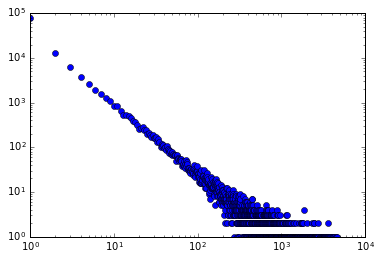

In [8]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    feature_counts = np.asarray(x.astype(bool).sum(axis=0))[0]
    print max(feature_counts)
    feature_user_counts = np.bincount(feature_counts)[1:]
    print feature_user_counts
    user_counts = np.arange(1, len(feature_user_counts) + 1)
    pl.plot(user_counts, feature_user_counts, 'bo')

    pl.xscale("log")
    pl.yscale("log")
    return feature_counts

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [9]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

In [11]:
print X1.shape

(4925, 3494)


Вариант задания генерируется на основании вашего ника в техносфере.

In [10]:
USER_NAME = "a.tolkachev"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [11]:
class MyLogisticRegression():

    def __init__(self, l2 = 1):
        self.l2 = l2

    def log_likelihood(self, w):
        p = self.probability(w)
        loglikelihood = self.labels*np.log(p+1e-24) + (1-self.labels)*np.log(1-p+1e-24)
        loglikelihood = -1*loglikelihood.sum()
        loglikelihood += self.l2*np.power(w, 2).sum()/2
        return loglikelihood

    def probability(self, w):
        return np.clip(1/(1+np.exp(-self.features.dot(w))), 1e-5, 0.9999)

    def log_likelihood_gradient(self, w):
        error = -self.labels + self.probability(w)
        product = self.features.transpose().dot(error)
        product -= self.l2 * w
        return product
    
    def log_likelihood_hessian(self, w):
        error = self.probability(w) * (1 - self.probability(w))
        error = np.squeeze(np.asarray(error))
        err_matr = np.diag(error)
        return (self.features.transpose()).dot(err_matr).dot(self.features)

    def newton_method(self, func, w0, eps):
        it = 0
        eta = 1e-3
        max_iter = 5*1e2
        diff = np.inf
        grad = nd.Gradient(func)#log_likelihood_gradient#
        hess = nd.Hessian(func)#log_likelihood_hessian#
        w_loc = np.copy(w0)
        while (np.fabs(diff) > eps) and (it < max_iter):
            w_prev = np.copy(w_loc)
            it+=1
            g = grad(np.squeeze(np.asarray(w_loc))).reshape(5,1)#grad(w_loc)#
            H = hess(np.squeeze(np.asarray(w_loc)))#hess(w_loc)#
            d = -np.linalg.inv(H).dot(g)
            w_loc += eta * d
            diff = np.linalg.norm((w_prev - w_loc))
        print 'it =', it
        print np.fabs(diff)
        return w_loc 
        
    def fit(self, X, y):
        self.labels = y.reshape(y.size,1)
        w0 = np.ones((x_iris.shape[1]+1,1))-0.5
        self.features = np.ones((X.shape[0],X.shape[1]+1))
        self.features[:,1:] = X
        self.coef = self.newton_method(
                    func = self.log_likelihood,
                    w0 = w0,
                    eps = 1e-5
                 )
        return self

    def predict_probabilty(self, X):
        mean_x = X.mean(axis=0)
        std_x = X.std(axis=0)
        features = np.ones((X.shape[0],X.shape[1]+1))
        features[:,1:] = (X-mean_x)/std_x
        prob1 = 1/(1+np.exp(-features.dot(self.coef)))
        prob0 = 1 - prob1
        prob = np.column_stack((prob0, prob1))
        return prob

    def get_coefficients(self):
        return self.coef.T[0]

In [12]:
lr = MyLogisticRegression(l2 = 10)

In [36]:
iris = ds.load_iris()
x_iris = iris.data[::5]
y_iris = iris.target[::5]

In [37]:
lr.fit(x_iris, y_iris)

it = 500
0.00038020348325


<__main__.MyLogisticRegression instance at 0x7f355e0ba170>

In [38]:
res = lr.predict_probabilty(iris.data[1::5])
#print res

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [39]:
def auroc(y_prob, y_true):
    fpr, tpr, thresholds = sm.roc_curve(y_true, y_prob, pos_label=1)
    return sm.auc(fpr, tpr)

In [42]:
iris.data[1::5].shape

(30, 4)

In [43]:
auroc(res[:, 1:], iris.target[1::5])

0.64000000000000001

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [43]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    return C.index(max(C))

index = select_reg_parameter(C, X1, Y)
print index


7


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

In [44]:
def classify(X, Y, test_size, C):
    tpr = [1] * 2400
    fpr = [0.01] * 2400
    roc_auc = 0.51
    
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    
    # Your code here
    
    return

plot_roc_curve(tpr, fpr, roc_auc)

Area under the ROC curve : 0.510000


С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.